# App Brainstorm 1
- How does our classifier compare to Song Sleuth?
- What single species am I hearing?
    - Single pred for whole rec
- What multiple species am I hearing?
    - Top k preds for whole rec with cutoff
- What species at what times am I hearing?
    - Segment rec at multiple time granularities (~a few), single pred per segment, labeled with (start, stop)
- What xc recs are similar to this one?
    - ??? e.g. whole/segmented input rec? whole/segmented xc recs?

In [ ]:
from notebooks import *

In [ ]:
# Load model
search = joblib.load('/'.join([
    f'{artifact_dir}',
    ','.join([
        "%s,estimator=Search(%s,classifier='%s',random_state=0)" % (
            # 'eval-na-ca/split_i=0,train=2688,test=672,classes=168', 'n_species=168,n_recs=1.0',
            # 'cls=logreg_ovr,solver=liblinear,C=0.05',
            'eval-na-dan170/split_i=0,train=2693,test=674,classes=170', 'n_species=170,n_recs=1.0',
            'cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',
        ),
    ]),
    'estimator.pkl',
]))

In [ ]:
# HACK FIXME Why doesn't search.projection.skm_ exist after unpickle?
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))
search.projection = projection
# These both work...
joblib_loads(joblib_dumps(projection)).skm_
joblib_loads(joblib_dumps(search)).projection.skm_

[17:56:55.223] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Featurize
recs = (
    # Load
    search.projection.features.load.recs(datasets=['recordings'])
    # Add .audio
    .assign(audio=lambda df: search.projection.features.load.audio(df, scheduler='threads'))
    # Add .created_at, .audio_sha, .audio_id
    .assign(
        created_at=lambda df: pd.to_datetime(df.path.map(lambda x: (Path(data_dir) / x).stat().st_ctime) * 1e9),
        audio_sha=lambda df: df.audio.map(lambda x: sha1hex(x.unbox._data)),
        audio_id=lambda df: df.apply(axis=1, func=lambda row: '-'.join([
            row.created_at.date().isoformat().replace('-', ''),
            row.audio_sha[:4],
        ])),
    )
    .set_index('audio_id')
    # Add .feat
    .pipe(search.projection.transform, override_scheduler='synchronous')
    # Ergonomics
    .pipe(df_reorder_cols, first=['created_at'])
    .sort_values('created_at', ascending=False)
)
display(
    df_summary(recs).T,
    recs[:10],
)

[17:56:55.384] DEBUG  Load.audio:in
  len(recs): 120
  len(recs) per dataset: {recordings: 120}
[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[######################                                                                    ] | 25% Completed |  0.3s

[##########################################################################################] | 100% Completed |  0.4s

[17:56:55.833] DEBUG  Load.audio:out
  len(audio): 120


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
created_at,datetime64[ns],15360,120,120,32.0,NaN,NaN,2018-04-08 22:57:39,2018-04-08 22:57:40,2018-04-16 18:39:06,2018-04-30 03:31:22,2018-06-23 18:14:47
dataset,object,7080,120,120,1.0,NaN,NaN,recordings,recordings,recordings,recordings,recordings
species,category,6360,120,120,35.0,NaN,NaN,MOUQ,BEWR,_UNK,_UNK,_UNK
species_com_name,category,7221,120,120,35.0,NaN,NaN,Mountain Quail,Bewick's Wren,Unknown,Unknown,Unknown
species_query,object,6360,120,120,35.0,NaN,NaN,AMBI,MAWR,_UNK,_UNK,_UNK
duration_s,float64,2880,120,120,119.0,8.526e+01,8.116e+01,3.81,39.5,59.9,102,537
samples_mb,float64,2880,120,120,119.0,3.586e+00,3.413e+00,0.16,1.66,2.52,4.28,22.6
samples_n,int64,3360,120,120,119.0,1.880e+06,1.790e+06,83968,871839,1320202,2244643,11848832
basename,object,10624,120,120,120.0,NaN,NaN,"ACWO,NOFL,SPTO spotted towhee, acorn woodpecker, flicker","HAWO hairy woodpecker chirps, dog park noise","RTHA red tailed hawk, noise, talking","crow, not phoebe, hummingbird",wren- maybe house- maybe not bewicks- coyote hills


,created_at,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path,audio,audio_sha,feat
audio_id,,,,,,,,,,,,,,,
20180623-d880,2018-06-23 18:14:47,recordings,_UNK,Unknown,_UNK,456.0,19.20,10048562,WIWA-HOFI-WCSP-NUWO-BCCH good test data- long- needs segmenting- glen canyon,Unknown - _UNK,recordings/WIWA-HOFI-WCSP-NUWO-BCCH good test data- long- needs segmenting- glen canyon,recordings/WIWA-HOFI-WCSP-NUWO-BCCH good test data- long- needs segmenting- glen canyon.wav,"box(unbox=recordings/WIWA-HOFI-WCSP-NUWO-BCCH good test data- long- needs segmenting- glen canyon: 1 channels, 16 bit, sampled @ 22.05 kHz, 455.717s long)",d8808349dfe5a1c47becbb1a4f086fbfb00ea5ff,[ 3.374e-02 8.833e-04 4.069e-01 -8.783e-02 1.821e-02 2.963e-02 2.362e-02 -1.251e-01 4.310e-01 -6.518e-02\n -8.337e-02 -1.023e-01 -7.038e-02 -1.278e-01 -1.935e-01 -7.2...
20180623-1a88,2018-06-23 18:14:45,recordings,WIWA,Wilson's Warbler,WIWA,27.7,1.16,610585,WIWA lands end,Wilson's Warbler - WIWA,recordings/WIWA lands end,recordings/WIWA lands end.wav,"box(unbox=recordings/WIWA lands end: 1 channels, 16 bit, sampled @ 22.05 kHz, 27.691s long)",1a88bb8a1a9f45cb9d5ae19caf81bea3f057f9eb,[ 1.605e-01 -1.840e-02 4.749e-01 -4.782e-02 1.475e-02 -3.053e-02 1.519e-03 -1.861e-01 3.626e-01 -7.413e-02\n -6.740e-02 -1.368e-02 -5.846e-02 8.216e-02 4.719e-02 3.4...
20180623-e46b,2018-06-23 18:14:44,recordings,_UNK,Unknown,_UNK,102.0,4.28,2244643,wilson-s snipe- low trembly -1000hz-,Unknown - _UNK,recordings/wilson-s snipe- low trembly -1000hz-,recordings/wilson-s snipe- low trembly -1000hz-.wav,"box(unbox=recordings/wilson-s snipe- low trembly -1000hz-: 1 channels, 16 bit, sampled @ 22.05 kHz, 101.798s long)",e46b0b5ebb9b6ba3d144c098c9a33c1caea1ba7d,[ 4.484e-02 -9.059e-03 4.235e-01 -8.516e-02 8.941e-02 -2.774e-02 9.688e-02 1.242e-01 5.018e-01 -7.206e-02\n -2.476e-01 -4.852e-02 -3.549e-02 -1.453e-01 -2.014e-02 2.0...
20180623-eb57,2018-06-23 18:14:43,recordings,_UNK,Unknown,_UNK,55.3,2.33,1220416,SOSP-WIWA Burleigh Murray,Unknown - _UNK,recordings/SOSP-WIWA Burleigh Murray,recordings/SOSP-WIWA Burleigh Murray.wav,"box(unbox=recordings/SOSP-WIWA Burleigh Murray: 1 channels, 16 bit, sampled @ 22.05 kHz, 55.348s long)",eb57d0da7fd07a905a60476bc3c807de327653fd,[-7.605e-03 7.994e-02 3.820e-01 -1.071e-01 6.709e-02 1.099e-01 3.593e-02 -1.138e-01 4.256e-01 4.931e-02\n -2.420e-01 2.072e-01 -2.046e-03 -1.623e-01 9.325e-02 -1.9...
20180623-5255,2018-06-23 18:14:42,recordings,_UNK,Unknown,_UNK,92.7,3.90,2044677,Q- pull this apart- OCWA- ash throated fly- pacific fly- nuttals- wind noise,Unknown - _UNK,recordings/Q- pull this apart- OCWA- ash throated fly- pacific fly- nuttals- wind noise,recordings/Q- pull this apart- OCWA- ash throated fly- pacific fly- nuttals- wind noise.wav,"box(unbox=recordings/Q- pull this apart- OCWA- ash throated fly- pacific fly- nuttals- wind noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 92.729s long)",52551c0ec0b4040743dfe82b7d4bf79e8a1e888e,[-2.208e-02 6.746e-02 5.414e-01 -1.535e-01 7.945e-02 1.157e-01 1.792e-02 -1.972e-01 9.479e-01 1.442e-02\n -1.554e-01 -2.874e-02 9.944e-03 -1.407e-01 -1.305e-01 -1.2...
20180623-fb5c,2018-06-23 18:14:41,recordings,_UNK,Unknown,_UNK,19.3,0.81,424696,q what is this constant pitch slow trill that i should know- glen canyon,Unknown - _UNK,recordings/q what is this constant pitch slow trill that i should know- glen canyon,recordings/q what is this constant pitch slow trill that i should know- glen canyon.wav,"box(unbox=recordings/q what is this constant pitch slow trill that i should know- glen canyon: 1 channels, 16 bit, sampled @ 22.05 kHz, 19.261s long)",fb5c55831225e96ddab60586b98c406e384ec16e,[ 7.875e-02 1.176e-04 7.793e-02 -5.431e-02 -5.992e-02 -9.266e-03 3.999e-02 -6.514e-02 1.258e-01 6.752e-02\n -7.683e-02 -2.352e-02 -8.369e-02 2.078e-02 -3.442e-02 -4.0...
20180623-a823,2018-06-23 18:14:40,recordings,_UNK,Unknown,_UNK,102.0,4.30,2255386,q what are these notes- Burleigh Murray,

In [ ]:
# Feature: .spectro (slow)
#   - Cache control is knotty here: _spectro @cache is disabled to avoid disk blow up on xc, but we'd benefit from it for recordings
#   - But the structure of the code makes it very tricky to enable @cache just for _spectro from one caller and not the other
#   - And the app won't have the benefit of caching anyway, so maybe punt and ignore?
recs = (recs
    .assign(spectro=lambda df: search.projection.features.spectro(df, scheduler='threads'))  # threads >> sync, procs
)

[17:56:57.222] DEBUG  Features.spectros:in
  len(recs): 120
  len(recs) per dataset: {recordings: 120}
  sum(duration_h): 2.84
  sum(samples_mb): 430.0
  sum(samples_n): 225596521


[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.4s

[                                                                                          ] | 0% Completed |  0.5s

[                                                                                          ] | 0% Completed |  0.7s

[                                                                                          ] | 0% Completed |  0.8s

[                                                                                          ] | 0% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.1s

[####                                                                                      ] | 5% Completed |  1.2s

[####                                                                                      ] | 5% Completed |  1.3s

[#######                                                                                   ] | 8% Completed |  1.4s

[#########                                                                                 ] | 10% Completed |  1.5s

[#########                                                                                 ] | 10% Completed |  1.7s

[#########                                                                                 ] | 10% Completed |  1.8s

[##########                                                                                ] | 11% Completed |  1.9s

[##########                                                                                ] | 11% Completed |  2.0s

[############                                                                              ] | 13% Completed |  2.1s

[############                                                                              ] | 13% Completed |  2.2s

[############                                                                              ] | 13% Completed |  2.3s

[############                                                                              ] | 14% Completed |  2.4s

[#############                                                                             ] | 15% Completed |  2.5s

[###############                                                                           ] | 16% Completed |  2.7s

[###############                                                                           ] | 16% Completed |  2.9s

[##################                                                                        ] | 20% Completed |  3.0s

[###################                                                                       ] | 21% Completed |  3.1s

[######################                                                                    ] | 25% Completed |  3.3s

[######################                                                                    ] | 25% Completed |  3.5s

[########################                                                                  ] | 26% Completed |  3.6s

[########################                                                                  ] | 26% Completed |  3.8s

[#########################                                                                 ] | 28% Completed |  3.9s

[###########################                                                               ] | 30% Completed |  4.0s

[############################                                                              ] | 31% Completed |  4.1s

[############################                                                              ] | 31% Completed |  4.2s

[############################                                                              ] | 31% Completed |  4.3s

[##############################                                                            ] | 33% Completed |  4.5s

[##############################                                                            ] | 33% Completed |  4.6s

[##############################                                                            ] | 33% Completed |  4.8s

[###############################                                                           ] | 35% Completed |  4.9s

[##################################                                                        ] | 38% Completed |  5.0s

[####################################                                                      ] | 40% Completed |  5.2s

[####################################                                                      ] | 40% Completed |  5.3s

[####################################                                                      ] | 40% Completed |  5.4s

[#######################################                                                   ] | 43% Completed |  5.5s

[#######################################                                                   ] | 43% Completed |  5.7s

[#######################################                                                   ] | 44% Completed |  5.8s

[###############################################                                           ] | 52% Completed |  5.9s

[#################################################                                         ] | 55% Completed |  6.0s

[#################################################                                         ] | 55% Completed |  6.1s

[##################################################                                        ] | 55% Completed |  6.2s

[####################################################                                      ] | 58% Completed |  6.4s

[####################################################                                      ] | 58% Completed |  6.5s

[####################################################                                      ] | 58% Completed |  6.6s

[#########################################################                                 ] | 63% Completed |  6.7s

[############################################################                              ] | 66% Completed |  6.9s

[#############################################################                             ] | 68% Completed |  7.0s

[##############################################################                            ] | 69% Completed |  7.1s

[##############################################################                            ] | 70% Completed |  7.2s

[##############################################################                            ] | 70% Completed |  7.4s

[##################################################################                        ] | 73% Completed |  7.5s

[#####################################################################                     ] | 76% Completed |  7.7s

[#####################################################################                     ] | 76% Completed |  7.8s

[#####################################################################                     ] | 76% Completed |  7.9s

[#####################################################################                     ] | 76% Completed |  8.1s

[#####################################################################                     ] | 76% Completed |  8.2s

[######################################################################                    ] | 78% Completed |  8.3s

[#######################################################################                   ] | 79% Completed |  8.5s

[###########################################################################               ] | 83% Completed |  8.7s

[#################################################################################         ] | 90% Completed |  8.8s

[#################################################################################         ] | 90% Completed |  8.9s

[#################################################################################         ] | 90% Completed |  9.0s

[#####################################################################################     ] | 95% Completed |  9.2s

[########################################################################################  ] | 98% Completed |  9.3s

[##########################################################################################] | 100% Completed |  9.4s

[17:57:07.792] DEBUG  Features.spectros:out
  (f, sum(t)): [40, 881054]


In [ ]:
# TODO Usability improvements
#   - [ ] Search.species_probs: add args to limit results: top_k, at_least_p
#   - [ ] Return mtime from load.recs (that's the sorting I want for dataset='recordings')

In [ ]:
def is_species_prob(x):
    return isinstance(x, list) and len(x) == 2 and isinstance(x[0], float) and isinstance(x[1], str)

def style_preds_cell(x, species_true, cmap=mpl.cm.magma, cmap_min=.5, species_true_style='background: #336'):
    styles = []
    if is_species_prob(x):
        [p, species] = x
        styles.append('color: %s' % scale_color_cmap(cmap).palette(cmap_min + p * (1 - cmap_min)))
        if species == species_true:
            styles.append(species_true_style)
    return '; '.join(styles)

def style_preds(preds: DF):
    return (preds
        .style.apply(axis=1, func=lambda row: row.map(partial(style_preds_cell, species_true=row.species)))
        # .T.style.apply(axis=0, func=lambda row: row.map(partial(style_preds_cell, species_true=row.species)))
    )

In [ ]:
species_us = com_names_to_species(*com_names['us'])
species_ca = com_names_to_species(*com_names['ca'])
species_dan170 = com_names_to_species(*com_names['dan170'])

In [ ]:
basenames = '*_201*'  # Recs from Song Sleuth
top_k = 10
preds = (recs
    # [:10]
    # [lambda df: df.basename.isin(fnmatch.filter(recs.basename, basenames))]
    [['basename', 'duration_s', 'species_com_name', 'species', 'audio', 'spectro', 'feat']]
    .assign(
        in_model=lambda df: df.species.isin(search.classes_),
        # in_dan170=lambda df: df.species.isin(species_dan170),
        # in_ca=lambda df: df.species.isin(species_ca),
        # in_us=lambda df: df.species.isin(species_us),
        coverage_error=lambda df: SearchEvals(search=search, recs=df).coverage_errors(),
    )
    .pipe(lambda df: df.join(how='left', other=(df
        .pipe(search.species_probs)
        .drop(columns=['species_true'])
        .applymap(lambda x: x if not is_species_prob(x) else [round_sig(x[0], 2), x[1]])
        .T[:1 + top_k].T
    )))
    .drop(columns=['feat'])
    .pipe(df_reorder_cols, last=['audio', 'spectro'])
    .sort_values(['in_model', 'species', 'coverage_error'], ascending=[False, True, True]).reset_index(drop=True)
)
display(
    style_preds(preds),
)

,basename,duration_s,species_com_name,species,in_model,coverage_error,0,1,2,3,4,5,6,7,8,9,10,audio,spectro
0,MOUQ good clean segments near end- lots of noise- stonewall in sierraville,230,Mountain Quail,MOUQ,True,91,"[0.51, 'SOGR']","[0.053, 'CONI']","[0.048, 'WREN']","[0.036, 'WEBL']","[0.031, 'CLNU']","[0.03, 'CORA']","[0.019, 'PUMA']","[0.018, 'MAWR']","[0.015, 'SEWR']","[0.015, 'MONQ']","[0.013, 'LEBI']","box(unbox=recordings/MOUQ good clean segments near end- lots of noise- stonewall in sierraville: 1 channels, 16 bit, sampled @ 22.05 kHz, 230.280s long)",
1,OSPR osprey- very noisy- fault day,89.6,Osprey,OSPR,True,75,"[0.19, 'MONQ']","[0.1, 'EUCD']","[0.071, 'SOGR']","[0.069, 'HOOR']","[0.05, 'MAWR']","[0.045, 'RODO']","[0.041, 'LEBI']","[0.036, 'WREN']","[0.026, 'CLNU']","[0.023, 'COGR']","[0.021, 'DCCO']","box(unbox=recordings/OSPR osprey- very noisy- fault day: 1 channels, 16 bit, sampled @ 22.05 kHz, 89.637s long)",
2,RTHA red tailed hawk,30.6,Red-tailed Hawk,RTHA,True,4,"[0.068, 'MOCH']","[0.046, 'BLPW']","[0.043, 'CONI']","[0.032, 'RTHA']","[0.032, 'LEGO']","[0.031, 'WTKI']","[0.028, 'CMWA']","[0.028, 'SUTA']","[0.025, 'AMRE']","[0.025, 'WCSP']","[0.022, 'BTNW']","box(unbox=recordings/RTHA red tailed hawk: 1 channels, 16 bit, sampled @ 22.05 kHz, 30.583s long)",
3,"RTHA red tailed hawk, noise, talking",44.8,Red-tailed Hawk,RTHA,True,11,"[0.28, 'EUCD']","[0.12, 'BTPI']","[0.085, 'MONQ']","[0.051, 'RODO']","[0.044, 'GHOW']","[0.028, 'MODO']","[0.027, 'DCCO']","[0.027, 'GBHE']","[0.023, 'CARW']","[0.021, 'HOOR']","[0.018, 'RTHA']","box(unbox=recordings/RTHA red tailed hawk, noise, talking: 1 channels, 16 bit, sampled @ 22.05 kHz, 44.770s long)",
4,"RTHA red tailed hawk, noise",42.1,Red-tailed Hawk,RTHA,True,39,"[0.099, 'CONI']","[0.051, 'DCCO']","[0.043, 'NRWS']","[0.039, 'RODO']","[0.037, 'DOWO']","[0.027, 'BESP']","[0.024, 'SOGR']","[0.021, 'WCSP']","[0.021, 'WREN']","[0.017, 'GBHE']","[0.017, 'LEBI']","box(unbox=recordings/RTHA red tailed hawk, noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 42.129s long)",
5,"RTHA red tailed hawk, noise (2)",52.4,Red-tailed Hawk,RTHA,True,76,"[0.18, 'SOGR']","[0.062, 'ANHU']","[0.052, 'CACW']","[0.046, 'BUOW']","[0.044, 'CONI']","[0.041, 'PUMA']","[0.04, 'WREN']","[0.032, 'LEBI']","[0.032, 'HOSP']","[0.02, 'SUTA']","[0.018, 'NRWS']","box(unbox=recordings/RTHA red tailed hawk, noise (2): 1 channels, 16 bit, sampled @ 22.05 kHz, 52.400s long)",
6,COPO - mitchell canyon,140,Common Poorwill,COPO,True,77,"[0.29, 'DCCO']","[0.16, 'BTPI']","[0.13, 'RODO']","[0.069, 'RUHU']","[0.03, 'RWBL']","[0.03, 'SEWR']","[0.028, 'CONI']","[0.027, 'EUCD']","[0.026, 'MONQ']","[0.02, 'GBHE']","[0.017, 'GHOW']","box(unbox=recordings/COPO - mitchell canyon: 1 channels, 16 bit, sampled @ 22.05 kHz, 140.432s long)",
7,"HAWO hairy woodpecker chirps, dog park noise",56.4,Hairy Woodpecker,HAWO,True,35,"[0.11, 'HOSP']","[0.096, 'MONQ']","[0.067, 'MAWR']","[0.042, 'SOGR']","[0.035, 'BHCO']","[0.034, 'LEBI']","[0.032, 'HEWA']","[0.03, 'BTNW']","[0.025, 'RWBL']","[0.022, 'BTPI']","[0.021, 'YRWA']","box(unbox=recordings/HAWO hairy woodpecker chirps, dog park noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 56.436s long)",
8,HAWO hairy woodpecker (2),59.3,Hairy Woodpecker,HAWO,True,78,"[0.13, 'MAWR']","[0.12, 'WEKI']","[0.11, 'EUST']","[0.038, 'NOMO']","[0.032, 'RWBL']","[0.029, 'CLSW']","[0.028, 'BEWR']","[0.023, 'HOSP']","[0.02, 'SEWR']","[0.018, 'SOSP']","[0.017, 'NOHA']","box(unbox=recordings/HAWO hairy woodpecker (2): 1 channels, 16 bit, sampled @ 22.05 kHz, 59.312s long)",
9,PSFL pac slope flycatcher- kings rd,53.8,Pacific-slope Flycatcher,PSFL,True,76,"[0.17, 'BTPI']","[0.11, 'EUCD']","[0.08, 'SOGR']","[0.054, 'BHCO']","[0.048, 'MONQ']","[0.037, 'BTNW']","[0.034, 'RODO']","[0.034, 'GRHE']","[0.032, 'CACH']","[0.03, 'GCWA']","[0.027, 'MAWR']","box(unbox=recordings/PSFL pac slope flycatcher- kings rd: 1 channels, 16 bit, sampled @ 22.05 kHz, 53.782s long)",


,0
basename,MOUQ good clean segments near end- lots of noise- stonewall in sierraville
duration_s,230
species_com_name,Mountain Quail
species,MOUQ
audio,"box(unbox=recordings/MOUQ good clean segments near end- lots of noise- stonewall in sierraville: 1 channels, 16 bit, sampled @ 22.05 kHz, 230.280s long)"
spectro,
in_model,True
coverage_error,91
0,"[0.51, SOGR]"
1,"[0.053, CONI]"


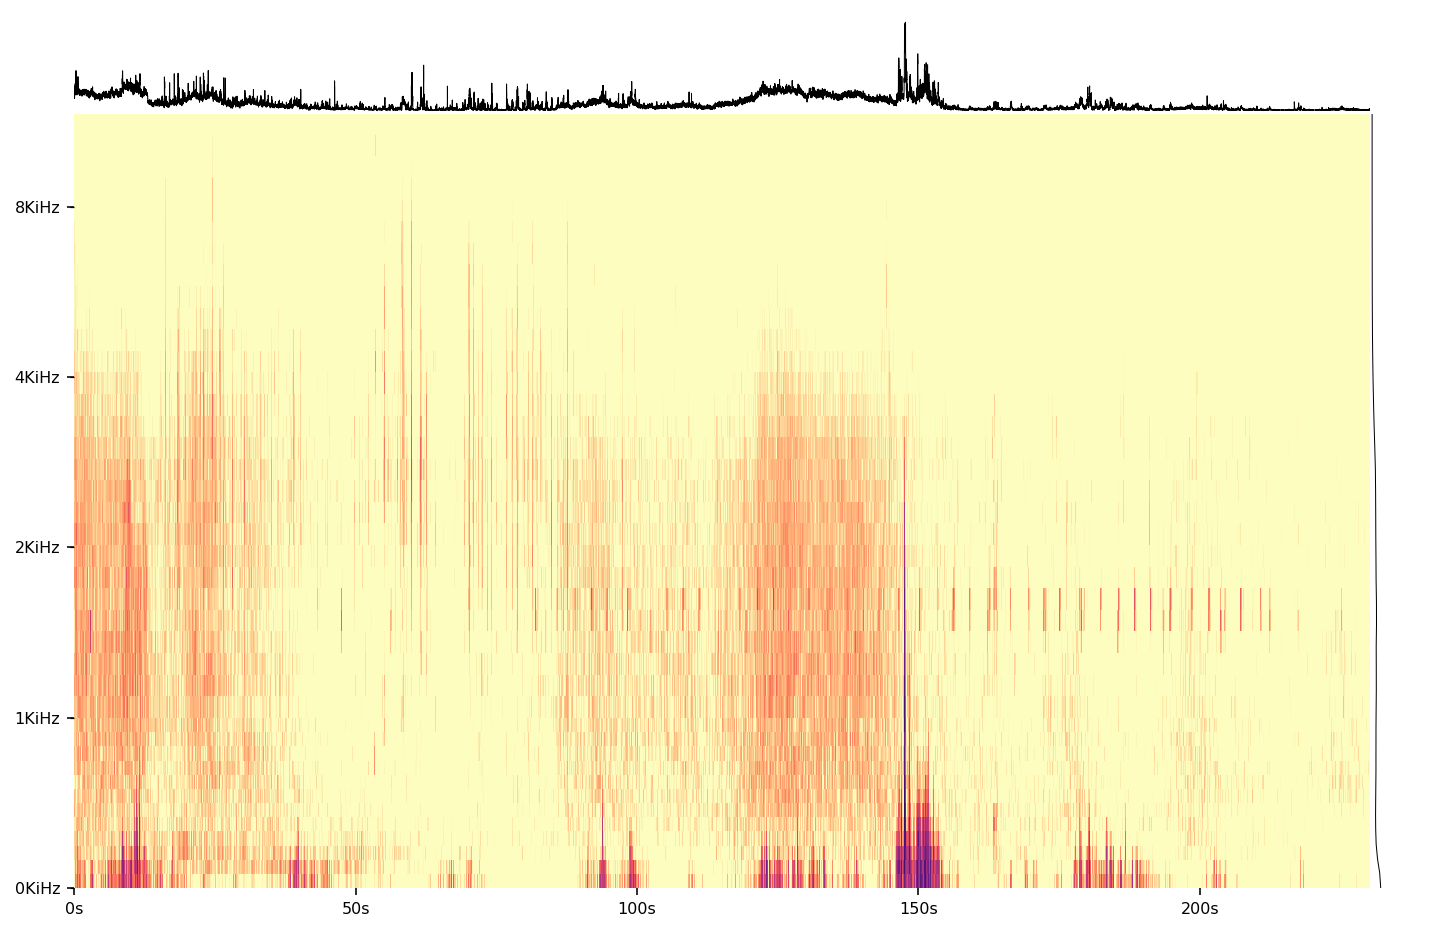

recordings/MOUQ good clean segments near end- lots of noise- stonewall in sierraville: 1 channels, 16 bit, sampled @ 22.05 kHz, 230.280s long

,1
basename,OSPR osprey- very noisy- fault day
duration_s,89.6
species_com_name,Osprey
species,OSPR
audio,"box(unbox=recordings/OSPR osprey- very noisy- fault day: 1 channels, 16 bit, sampled @ 22.05 kHz, 89.637s long)"
spectro,
in_model,True
coverage_error,75
0,"[0.19, MONQ]"
1,"[0.1, EUCD]"


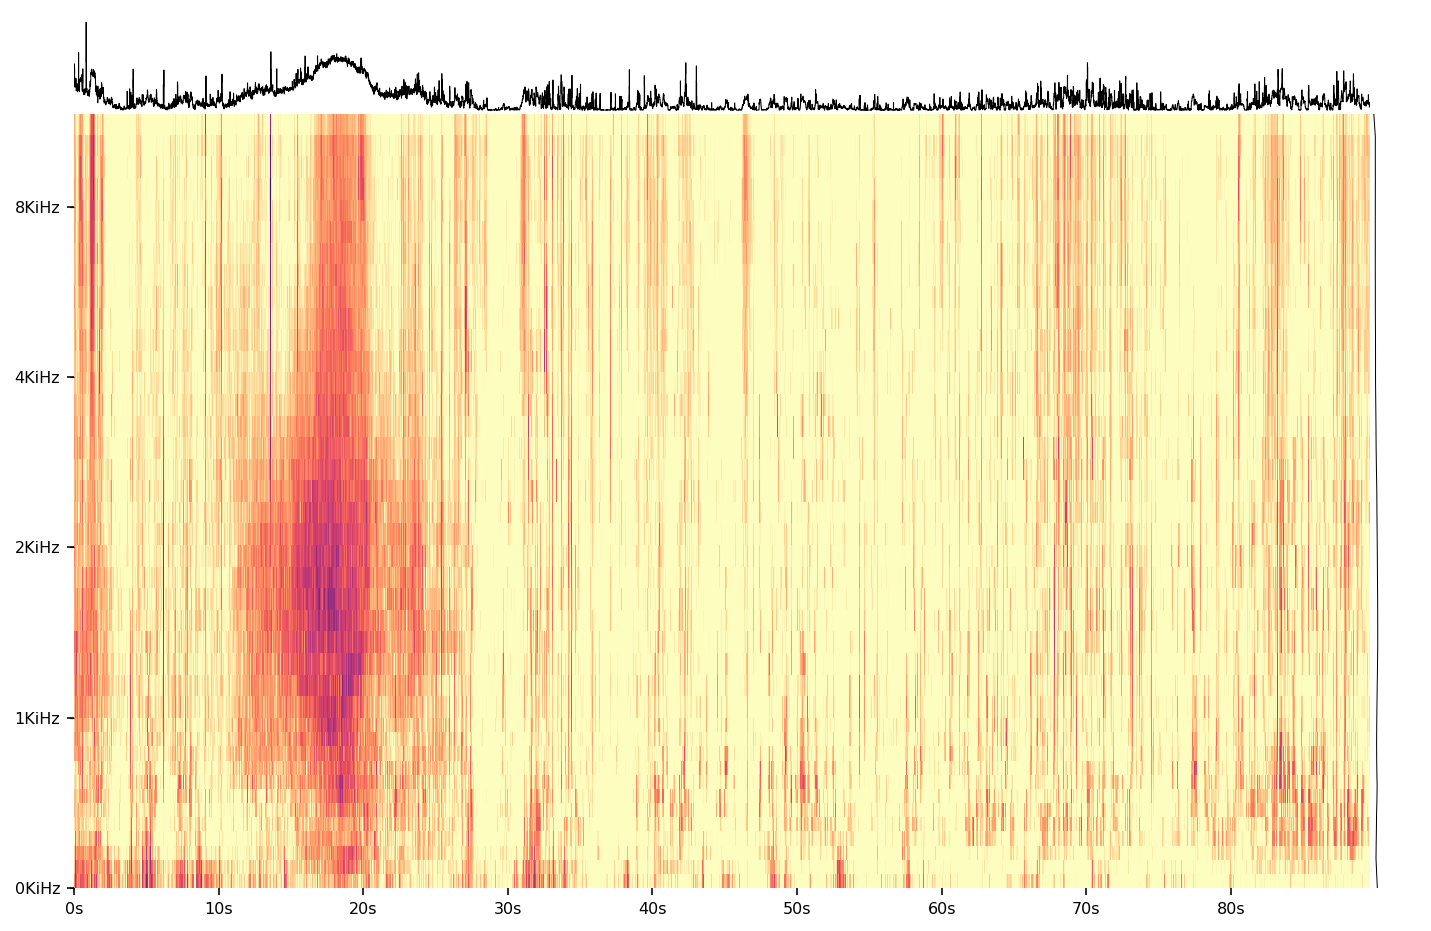

recordings/OSPR osprey- very noisy- fault day: 1 channels, 16 bit, sampled @ 22.05 kHz, 89.637s long

,2
basename,RTHA red tailed hawk
duration_s,30.6
species_com_name,Red-tailed Hawk
species,RTHA
audio,"box(unbox=recordings/RTHA red tailed hawk: 1 channels, 16 bit, sampled @ 22.05 kHz, 30.583s long)"
spectro,
in_model,True
coverage_error,4
0,"[0.068, MOCH]"
1,"[0.046, BLPW]"


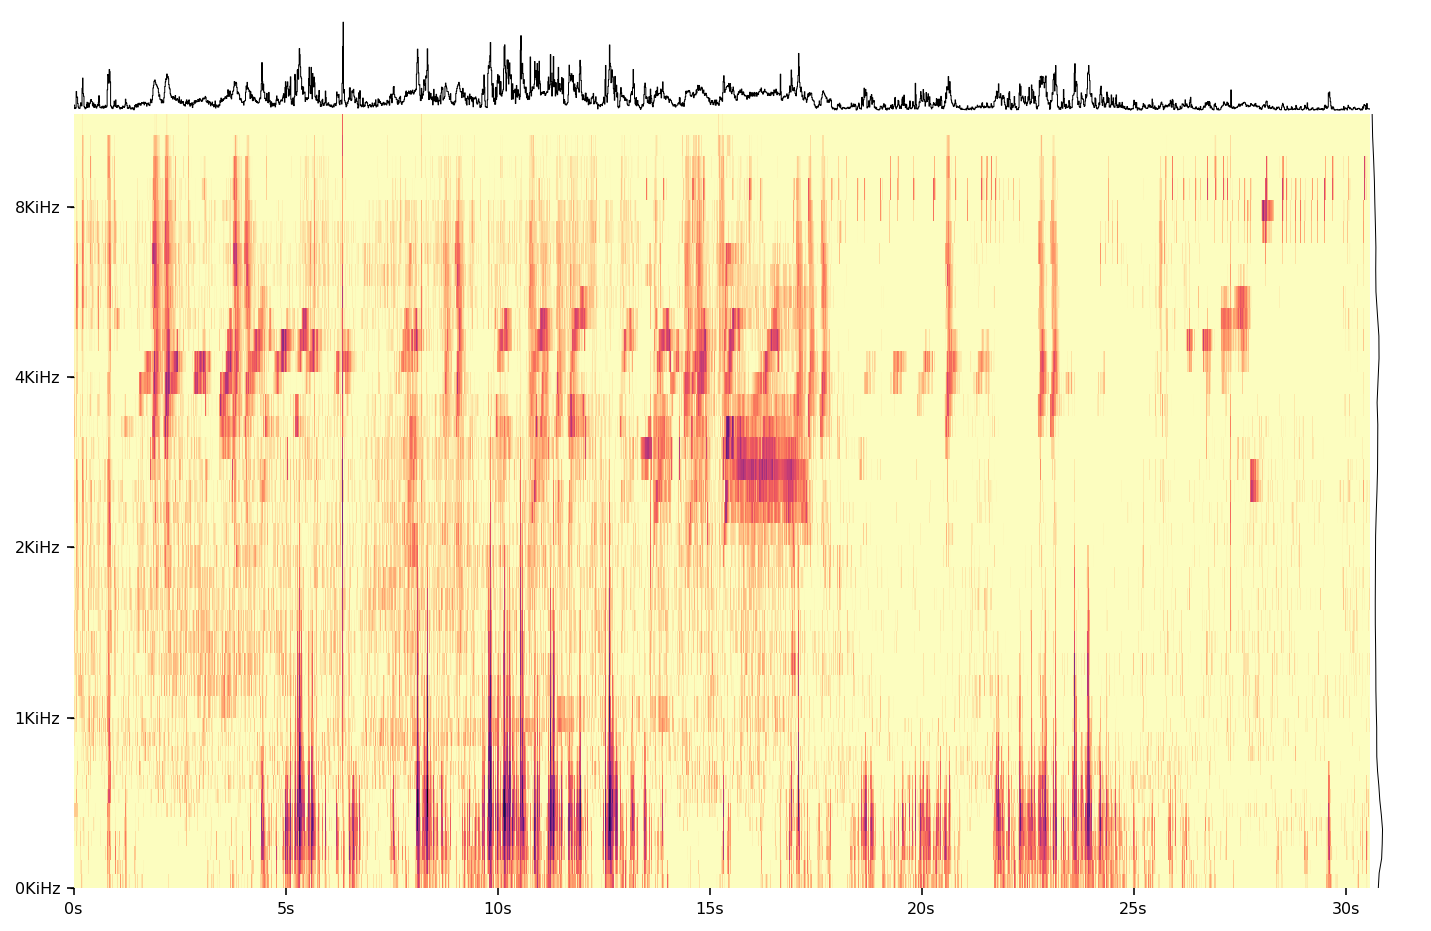

recordings/RTHA red tailed hawk: 1 channels, 16 bit, sampled @ 22.05 kHz, 30.583s long

In [ ]:
for pred in (list(df_rows(preds))
    [:3]
):
    display(DF([pred])
        .T
        # .pipe(style_preds)  # TODO Update style_preds to handle .T
    )
    pred.spectro.plot()